In [11]:
from TraitModel import *
from jupyterthemes import jtplot #внешний вид ноутбука и графиков
jtplot.style(theme='onedork')
%matplotlib inline

In [2]:
#get text data from db
conn = sqlite3.connect('ud.db')
c = conn.cursor()
query = 'SELECT DISTINCT owner_id, text FROM posts WHERE text IS NOT NULL AND text != "";'
texts = pd.read_sql(query, conn)
lens = np.array([len(str(t)) for t in texts.text])
trsh_up, trsh_lo = 9000, 700
lens = np.array([len(str(t)) for t in texts.text])
texts = texts[(lens < trsh_up) & (lens > trsh_lo)]
texts.shape

(2164, 2)

In [3]:
#load psychological data and transform traits
names_HEX = ['HEX1_eX', 'HEX2_A', 'HEX3_C', 'HEX4_E', 'HEX5_O', 'HEX6_H']
names_TWf = ['TWf1_eX', 'TWf2_A', 'TWf3_C', 'TWf4_E', 'TWf5_O', 'TWf6_H']
names_TWc = ['TWc1_eX', 'TWc2_A', 'TWc3_C', 'TWc4_N', 'TWc5_O', 'TWc6_H']
names_M = ['M'+i[3:] for i in names_HEX]
cols = ['id', 'sex'] + names_HEX + names_TWf + names_TWc
traits = pd.read_csv('data/survey_data.csv', sep=';', decimal=',', usecols=cols)

for i, t in enumerate(names_M):
    traits[t] = (traits[names_HEX[i]] + traits[names_TWf[i]] + traits[names_TWc[i]])/3

trait_names = names_HEX + names_TWf + names_TWc + names_M
print('trait high average low')
for trait in trait_names:
    scale = trait + '_nom'
    traits[scale] = traits[trait].apply(set_groups, dev=0.5)
    print(trait, [traits[scale].value_counts()[i] for i in range(3)])
    
trait_names = names_M

trait high average low
HEX1_eX [53, 51, 48]
HEX2_A [58, 51, 43]
HEX3_C [53, 52, 47]
HEX4_E [57, 48, 47]
HEX5_O [56, 50, 46]
HEX6_H [54, 50, 48]
TWf1_eX [57, 50, 45]
TWf2_A [55, 51, 46]
TWf3_C [62, 47, 43]
TWf4_E [53, 50, 49]
TWf5_O [57, 49, 46]
TWf6_H [53, 51, 48]
TWc1_eX [59, 49, 44]
TWc2_A [53, 52, 47]
TWc3_C [54, 52, 46]
TWc4_N [58, 49, 45]
TWc5_O [74, 40, 38]
TWc6_H [68, 44, 40]
M1_eX [61, 46, 45]
M2_A [59, 50, 43]
M3_C [64, 47, 41]
M4_E [69, 43, 40]
M5_O [65, 45, 42]
M6_H [66, 45, 41]


In [4]:
#join data
data_ = pd.merge(texts, traits, how='left', left_on='owner_id', right_on='id')
data_.shape

(2223, 52)

In [5]:
trm_logreg = TraitModel(xname = 'text',
                 traits = trait_names,
                 word_vectorizer = TfidfVectorizer(ngram_range=(1, 3), 
                     analyzer='word', 
                     tokenizer=word_tokenize, 
                     min_df = 30, 
                     max_df = 0.7, 
                     max_features = 10000),
                 pos_vectorizer = TfidfVectorizer(ngram_range=(2, 4), 
                     analyzer='word',  
                     min_df = 50, 
                     max_df = 0.5, 
                     max_features = 5000),
                 library = lib,
                 test_size = 0.12,
                 morph = pymorphy2.MorphAnalyzer(),
                 classifier = LogisticRegression,
                 classifier_params = {'max_iter':155, 
                                      'multi_class':'multinomial',
                                      'solver':'newton-cg'},
                 curves_params = {'steep':1.5, 'ec50':0.5, 'level':'max', 'adb':False}
                )

In [6]:
%%time
trm_logreg.fit(data_, mtype='n')

Wall time: 2min 54s


In [7]:
text = """
Иногда я пишу о книгах, которые произвели на меня впечатление. Писать большие отзывы сейчас не хочется, поэтому в порядке перечисления.
"Атлант расправил плечи" - за последнее время понравилась больше всего наряду с Довлатовым (но насчет последнего сомнений и не было). Почему-то раньше я думал, что это что-то вроде "Финансиста" Драйзера. Так же, видимо, думают и люди, рисующие мемы "сын маминой подруги расправил плечи". А на самом деле книга об альтернативной вселенной, где в США наступил социализм. Очень рекомендую.
Что до "Финансиста" Драйзера, то он надолго отбил у меня желание читать этого автора. Не потому что мне не интересно читать про рынок - наоборот, про рынок интересно. Но всё остальное там скучно, особенно герои. Может быть, так и было задумано, но я это не люблю.
Дилогия об Остапе Бендере - начинаются обе книги весело, кончаются обе книги уныло. Не столько с точки зрения событий, сколько с точки зрения того, как трансформируется язык. Поэтому от них остается неприятное ощущение, хотя написаны они ярко, весело и интересно. Впрочем, не пойти на такую сделку вряд ли можно было в условиях, в которых работали авторы.
"Три мушкетера". Ну, не побоюсь этого слова, такое. Занятно, но не более того - я сейчас даже с трудом вспомнил об этой книжке. Главный интерес книжка представляет с исторической точки зрения. В том числе и потому, что является убедительным доказательством, что во Франции в 17м веке был интернет и портативные телепорты - ну или по крайней мере бесстыдная сценарная магия.
Отто Кариус, "Тигры в грязи". Язык этой книги совершенно ужасен, может быть, потому что её писал солдат. Но прочитать очень стоит, потому что мало что может быть так ценно, как новая точка зрения на нечто хорошо знакомое.
"""
# text = "ты все про бизнес"

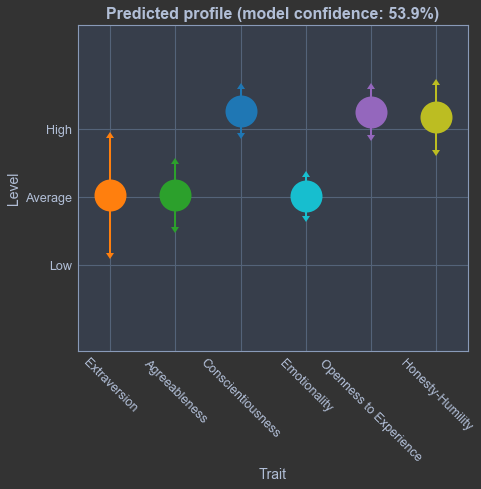

In [12]:
plot_traits(trm_logreg, text, strict=True)


CORRELATIONS

--------------------
M1_eX
--------------------
m_len_sent | M1_eX : r = -0.1
p_brkt_up | M1_eX : r = -0.18
p_1per | M1_eX : r = 0.1
p_quan | M1_eX : r = 0.14
p_racio | M1_eX : r = -0.1
p_VERB | M1_eX : r = 0.12
p_None | M1_eX : r = -0.13

--------------------
M2_A
--------------------
m_len_sent | M2_A : r = -0.17
pos_richness | M2_A : r = 0.14
p_fut | M2_A : r = 0.14
p_pres | M2_A : r = 0.1
p_perf | M2_A : r = 0.13
p_obscene | M2_A : r = 0.16
p_ADJF | M2_A : r = 0.11
p_NOUN | M2_A : r = 0.2
p_ADVB | M2_A : r = -0.16
p_VERB | M2_A : r = 0.15
p_None | M2_A : r = -0.21

--------------------
M3_C
--------------------
p_anim | M3_C : r = -0.11
p_past | M3_C : r = -0.19
p_fut | M3_C : r = 0.12
p_pres | M3_C : r = 0.12
p_obscene | M3_C : r = 0.17
p_slang | M3_C : r = 0.13
p_ADVB | M3_C : r = -0.13

--------------------
M4_E
--------------------
p_brkt | M4_E : r = 0.13
p_brkt_up | M4_E : r = 0.23
p_anim | M4_E : r = -0.14
p_1per | M4_E : r = 0.18
p_3per | M4_E : r = -0.17
p_N

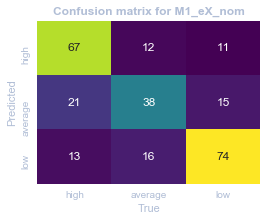


--------------------
M2_A_nom
--------------------

Accuracy on train: 94.07%
             precision    recall  f1-score   support

    average       0.92      0.98      0.95       856
       high       0.96      0.88      0.92       532
        low       0.95      0.94      0.95       568

avg / total       0.94      0.94      0.94      1956

Accuracy on test: 68.54%
             precision    recall  f1-score   support

    average       0.70      0.78      0.73       130
       high       0.59      0.53      0.56        60
        low       0.74      0.65      0.69        77

avg / total       0.68      0.69      0.68       267



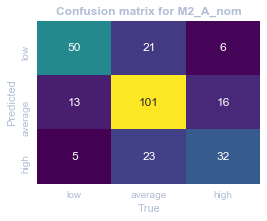


--------------------
M3_C_nom
--------------------

Accuracy on train: 93.81%
             precision    recall  f1-score   support

    average       0.93      0.92      0.93       546
       high       0.92      0.98      0.95       867
        low       0.97      0.89      0.93       543

avg / total       0.94      0.94      0.94      1956

Accuracy on test: 70.04%
             precision    recall  f1-score   support

    average       0.68      0.44      0.54        81
       high       0.72      0.90      0.80       122
        low       0.67      0.64      0.66        64

avg / total       0.70      0.70      0.69       267



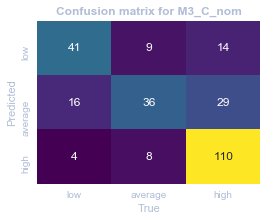


--------------------
M4_E_nom
--------------------

Accuracy on train: 92.89%
             precision    recall  f1-score   support

    average       0.96      0.84      0.90       442
       high       0.91      0.98      0.94       980
        low       0.95      0.92      0.93       534

avg / total       0.93      0.93      0.93      1956

Accuracy on test: 67.79%
             precision    recall  f1-score   support

    average       0.50      0.23      0.31        61
       high       0.72      0.89      0.80       144
        low       0.63      0.63      0.63        62

avg / total       0.65      0.68      0.65       267



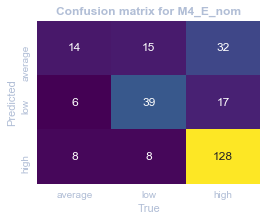


--------------------
M5_O_nom
--------------------

Accuracy on train: 89.01%
             precision    recall  f1-score   support

    average       0.95      0.63      0.76       361
       high       0.86      0.97      0.91       971
        low       0.93      0.92      0.92       624

avg / total       0.90      0.89      0.89      1956

Accuracy on test: 64.42%
             precision    recall  f1-score   support

    average       0.52      0.24      0.33        50
       high       0.62      0.78      0.69       124
        low       0.72      0.68      0.70        93

avg / total       0.64      0.64      0.63       267



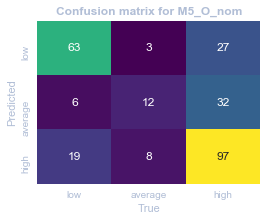


--------------------
M6_H_nom
--------------------

Accuracy on train: 90.03%
             precision    recall  f1-score   support

    average       0.88      0.99      0.93      1239
       high       0.98      0.69      0.81       291
        low       0.96      0.77      0.85       426

avg / total       0.91      0.90      0.90      1956

Accuracy on test: 69.29%
             precision    recall  f1-score   support

    average       0.70      0.97      0.81       168
       high       0.44      0.08      0.14        48
        low       0.75      0.35      0.48        51

avg / total       0.66      0.69      0.63       267



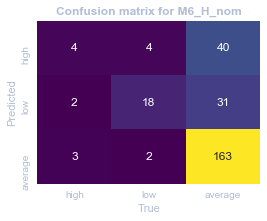


--------------------
Mean quality
--------------------
Mean Accuracy on train: 0.919
Mean Accuracy on test: 0.679

COEFS

--------------------
M1_eX_nom
--------------------

AVERAGE
      Coefficient                 Feature
4995     1.150675                  p_anim
1848     0.920531               цитаты из
698      0.907957         из прочитанного
1849     0.907957  цитаты из прочитанного
1396     0.868702            прочитанного
1210     0.808372                      он

HIGH
      Coefficient Feature
2002     1.510011       •
142      1.076075     бог
920      0.980952     мне
4988     0.964648   p_dot
170      0.962732    будь
870      0.959131  любовь

LOW
      Coefficient    Feature
4993     1.385709  p_brkt_up
1766     1.366556         ты
1377     1.178370        про
334      1.160910        все
820      0.998067    которые
137      0.959917     бизнес

--------------------
M2_A_nom
--------------------

AVERAGE
      Coefficient                 Feature
1766     1.409510      

In [13]:
trm_logreg.summary(correlations = 0.1, vec_tokens=12, coefs=6,
                   all_traits=True, clr=True, confusion=True)

In [14]:
%%time
trm_logreg.export(fname='model_logreg')

Wall time: 2.14 s


In [15]:
trm_rfr = TraitModel(xname = 'text',
                 traits = trait_names,
                 word_vectorizer = TfidfVectorizer(ngram_range=(1, 3), 
                     analyzer='word', 
                     tokenizer=word_tokenize, 
                     min_df = 30, 
                     max_df = 0.7, 
                     max_features = 10000),
                 pos_vectorizer = TfidfVectorizer(ngram_range=(2, 4), 
                     analyzer='word',  
                     min_df = 50, 
                     max_df = 0.5, 
                     max_features = 5000),
                 library = lib,
                 test_size = 0.12,
                 morph = pymorphy2.MorphAnalyzer(),
                 classifier = RandomForestRegressor,
                 classifier_params = {'n_estimators':200, 
                                      'max_features':'log2', 
                                      'min_samples_leaf':5, 
                                      'oob_score': True,},
                 curves_params = {'steep':1.5, 'ec50':0.5, 'level':'max', 'adb':False}
                )

In [16]:
%%time
trm_rfr.fit(data_, mtype='c')

Wall time: 1min 22s


In [17]:
trm_rfr.summary(correlations=0, vec_tokens=0)


PREDICTION QUALITY

--------------------
M1_eX
--------------------
MAPE on train: 14.63%
R2 on train: 0.498

MAPE on test: 19.19%
R2 on train: 0.219

--------------------
M2_A
--------------------
MAPE on train: 14.25%
R2 on train: 0.521

MAPE on test: 16.99%
R2 on train: 0.289

--------------------
M3_C
--------------------
MAPE on train: 14.34%
R2 on train: 0.509

MAPE on test: 16.74%
R2 on train: 0.217

--------------------
M4_E
--------------------
MAPE on train: 12.76%
R2 on train: 0.517

MAPE on test: 15.40%
R2 on train: 0.257

--------------------
M5_O
--------------------
MAPE on train: 14.54%
R2 on train: 0.484

MAPE on test: 18.45%
R2 on train: 0.186

--------------------
M6_H
--------------------
MAPE on train: 8.02%
R2 on train: 0.449

MAPE on test: 9.69%
R2 on train: 0.113

--------------------
Mean quality
--------------------
Mean R2 on train: 0.496
Mean R2 on test: 0.214
